In [0]:
!pip uninstall tensorflow -y
!pip install tensorflow

In [2]:
# Run this one if using google colab
from google.colab import drive
import sys
import os

drive.mount('/content/gdrive',True)
# sys.path.append("/content/xray_code/python_code")
sys.path.append("/content/gdrive/My Drive/xray_code/python_code")

if not os.path.exists("/content/xray_code"):
  !cp -r "/content/gdrive/My Drive/xray_code/" "/content/xray_code"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [27]:
%load_ext autoreload
%autoreload 2

from utils import *
from ml_utils import XrayTF
from tqdm import tqdm_notebook as tqdm
from threading import Thread
from constants import LOCAL_IMAGES_LOCATION

import pprint
import urllib.request as req
import matplotlib.pyplot as plt
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load csv if exist, if not get the original one and parse it


In [28]:
"""
SICKNESS = "Infiltration"
SICKNESS = "Pneumonia"
SICKNESS = "Mass"
SICKNESS = "Pneumothorax"
"""

SICKNESS = "Pneumonia"
csv_file = "normalized_xray_without_full_path.csv"
csv_file_full_path = f'/content/gdrive/My Drive/xray_code/sheet/{csv_file}'
POSITION = "PA"
GENDER = "F"

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCH = 100

# Do you want to perform cross validation or just one cycle only?
# Please reference within the constants.py
CROSS_VALIDATION = True 

# take existing if it exist
if os.path.exists(csv_file_full_path):
    df = pd.read_csv(csv_file_full_path)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
else:
    df = get_data_sheet()
    df = normalize_data_frame(df)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
    xray_class.df.to_csv(csv_file_full_path, index=False)

xray_class.df.head()

,Image Index,labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
0,https://images.marknavalta.com/v0.1/00000001_0...,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,https://images.marknavalta.com/v0.1/00000002_0...,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
2,https://images.marknavalta.com/v0.1/00000003_0...,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
3,https://images.marknavalta.com/v0.1/00000003_0...,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
4,https://images.marknavalta.com/v0.1/00000003_0...,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168


# Analyze our data set
- take a look at the distribution
- prepare data before splitting to test and train
  - Get image based on xray Position
  - Select a sickness and balance them
- Generate Age histogram

In [29]:
print(xray_class.df["View Position"].value_counts())
print("="*50)
print(xray_class.df.labels.value_counts())

PA    81630
AP    59907
Name: View Position, dtype: int64
No Finding            60361
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
Name: labels, dtype: int64


In [30]:
# Filter position
xray_class.df = xray_class.df[xray_class.df["View Position"] == POSITION]
xray_class.df = xray_class.df[xray_class.df["Patient Gender"] == GENDER]

# Pick a sickness
xray_class.use_one_label(SICKNESS, balance=True)


# Verify how balanced our data is
print(xray_class.df.labels.value_counts())
print(xray_class.df["Patient Gender"].value_counts())

No Finding    255
Pneumonia     255
Name: labels, dtype: int64
F    510
Name: Patient Gender, dtype: int64


(0.0, 100.0)

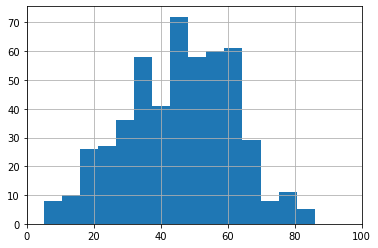

In [31]:
xray_class.df["Patient Age"].hist(bins=15).set_xlim(0,100)

# Download our data
- Parallel download from digital ocean
- prepend system path after download

In [0]:
!rm -rf /content/images
if not os.path.exists(LOCAL_IMAGES_LOCATION):
  !mkdir /content/images

  class Downloader(Thread):
    def __init__(self, file_url, save_path):
        Thread.__init__(self)
        self.file_url = file_url
        self.save_path = save_path

    def run(self):
        remaining_download_tries = 15

        while remaining_download_tries > 0:
            try:
                req.urlretrieve(self.file_url, self.save_path)
                time.sleep(0.1)
            except:
                print("error downloading " + self.file_url +
                      " on trial no: " + str(16 - remaining_download_tries))
                remaining_download_tries = remaining_download_tries - 1
                continue
            else:
                break
  # xray_class.df["Image Index"].apply(lambda x: Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ).start() )

  open_threads = [Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ) for x in xray_class.df["Image Index"]]
  started_threads = [thread.start() for thread in open_threads]
  joined_threads = [thread.join() for thread in open_threads]

In [33]:
#  let's now append the full system path
xray_class.df["Image Index"] = xray_class.df["Image Index"].apply(lambda x : LOCAL_IMAGES_LOCATION + x.split('/')[-1])
xray_class.df.head()

,Image Index,labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
57757,/content/images/00017280_000.png,No Finding,0,17280,67,F,PA,2534,2681,0.143000,0.143000
67453,/content/images/00020297_003.png,No Finding,3,20297,51,F,PA,2598,2991,0.143000,0.143000
45619,/content/images/00013712_001.png,No Finding,1,13712,18,F,PA,2992,2991,0.143000,0.143000
81039,/content/images/00026253_001.png,No Finding,1,26253,64,F,PA,2020,2021,0.194311,0.194311
4889,/content/images/00001582_014.png,No Finding,14,1582,32,F,PA,2048,2500,0.168000,0.168000


# Pre-processing of images and label
- split dataframe accordingly with equal numbers of labels in test and train
- batches image
- show image

In [34]:
# Split them into training and validation using NUM_IMAGES 
train_df, valid_df, test_df = xray_class.get_test_train_split_data(len(xray_class.df))

print(train_df.labels.value_counts())
print("="*50)
print(valid_df.labels.value_counts())
print("="*50)
print(test_df.labels.value_counts())


No Finding    204
Pneumonia     204
Name: labels, dtype: int64
No Finding    43
Pneumonia     38
Name: labels, dtype: int64
Pneumonia     13
No Finding     8
Name: labels, dtype: int64


In [35]:
# Create training and validation data batches using ImageDataGenerator
train_data = xray_class.generate_image(train_df, True)
val_data   = xray_class.generate_image(valid_df)
test_data   = xray_class.generate_image(test_df)

Found 408 validated image filenames belonging to 2 classes.
Found 81 validated image filenames belonging to 2 classes.
Found 21 validated image filenames belonging to 2 classes.


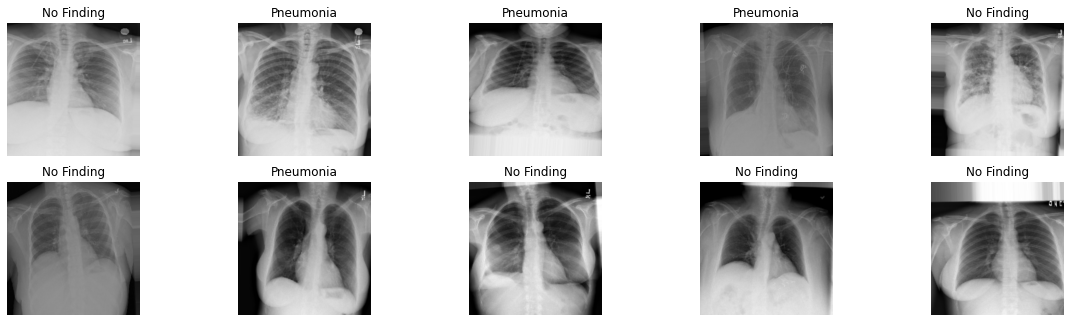

In [36]:
train_images, train_labels = next(train_data)
xray_class.show_25_images(train_images, train_labels)

# Perform model trainining
- fit our data using Categorical classification with metrics of accuracy and optimization Adam
- validate data
- save our model

In [0]:
if CROSS_VALIDATION:
  result = xray_class.cross_validation(EPOCH, train_data, val_data, test_data)
  pprint.pprint(result[max(result, key=float)])

  model = result[max(result, key=float)]["model"]
  a, b = model.evaluate(test_data)

  filename= f"{SICKNESS}_{b:.2f}"
  xray_class.save_model(model, filename)
  stop = result[max(result, key=float)]["stopping"]
else:
  if xray_class.model_exist(SICKNESS):
      model = xray_class.model_exist(SICKNESS)
      a, b = model.evaluate(test_data)
  else:
      model, stop = xray_class.train_model(EPOCH, train_data, val_data)
      stop = stop.stopped_epoch
      a, b = model.evaluate(test_data)
      
      filename= f"{SICKNESS}_{b:.2f}"
      xray_class.save_model(model, filename)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_18 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_42 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_24 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 17.6368 - accuracy: 0.5049 - val_loss: 7.4174 - val_accuracy: 0.4691
Epoch 2/100
13/13 [==============================] - 12s 904ms/step - loss: 4.1786 - accuracy: 0.5270 - val_loss: 1.7299 - val_accuracy: 0.5556
Epoch 3/100
13/13 [==============================] - 12s 911ms/step - loss: 1.1205 - accuracy: 0.5637 - val_loss: 0.6844 - val_accuracy: 0.5926
Epoch 4/100
13/13 [==============================] - 12s 915ms/step - loss: 0.6810 - accuracy: 0.5907 - val_loss: 0.6992 - val_accuracy: 0.5802
Epoch 5/100
13/13 [==============================] - 12s 911ms/step - loss: 0.7175 - accuracy: 0.5417 - val_loss: 0.6954 - val_accuracy: 0.6173
Epoch 6/100
13/13 [==============================] - 12s 906ms/step - loss: 0.6972 - accuracy: 0.6152 - val_loss: 0.6829 - val_accuracy: 0.6420
Epoch 7/100
13/13 [==============================] - 12s 920ms/step - loss: 0.6544 - accuracy: 0.

  ...
    to  
  ['...']


1/1 [==============================] - 1s 687ms/step - loss: 0.5753 - accuracy: 0.7143
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_19 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_44 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_25 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 2.3573 - accuracy: 0.5319 - val_loss: 1.0302 - val_accuracy: 0.6296
Epoch 2/100
13/13 [==============================] - 12s 920ms/step - loss: 1.6546 - accuracy: 0.5931 - val_loss: 0.9574 - val_accuracy: 0.5926
Epoch 3/100
13/13 [==============================] - 12s 917ms/step - loss: 1.1911 - accuracy: 0.5784 - val_loss: 0.8246 - val_accuracy: 0.6296
Epoch 4/100
13/13 [==============================] - 12s 920ms/step - loss: 0.8870 - accuracy: 0.6348 - val_loss: 0.6275 - val_accuracy: 0.6914
Epoch 5/100
13/13 [==============================] - 12s 912ms/step - loss: 0.8385 - accuracy: 0.6054 - val_loss: 0.6353 - val_accuracy: 0.6667
Epoch 6/100
13/13 [==============================] - 12s 914ms/step - loss: 0.6977 - accuracy: 0.6250 - val_loss: 0.7084 - val_accuracy: 0.4815
Epoch 7/100
13/13 [==============================] - 12s 912ms/step - loss: 0.6626 - accuracy: 0.6

  ...
    to  
  ['...']


1/1 [==============================] - 0s 407ms/step - loss: 0.5560 - accuracy: 0.6190
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_20 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_46 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_26 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 1.9511 - accuracy: 0.5074 - val_loss: 1.5957 - val_accuracy: 0.5802
Epoch 2/100
13/13 [==============================] - 12s 910ms/step - loss: 1.5035 - accuracy: 0.5784 - val_loss: 1.3039 - val_accuracy: 0.6049
Epoch 3/100
13/13 [==============================] - 12s 912ms/step - loss: 1.1714 - accuracy: 0.5956 - val_loss: 0.7746 - val_accuracy: 0.6420
Epoch 4/100
13/13 [==============================] - 12s 906ms/step - loss: 0.9974 - accuracy: 0.5809 - val_loss: 0.7227 - val_accuracy: 0.6049
Epoch 5/100
13/13 [==============================] - 12s 910ms/step - loss: 0.7910 - accuracy: 0.6029 - val_loss: 0.7484 - val_accuracy: 0.6296
Epoch 6/100
13/13 [==============================] - 12s 912ms/step - loss: 0.7871 - accuracy: 0.6422 - val_loss: 0.7422 - val_accuracy: 0.6790
Epoch 7/100
13/13 [==============================] - 12s 896ms/step - loss: 0.6967 - accuracy: 0.6

  ...
    to  
  ['...']


1/1 [==============================] - 0s 406ms/step - loss: 0.5735 - accuracy: 0.7143
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_21 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_48 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_27 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 15.7171 - accuracy: 0.5441 - val_loss: 4.5755 - val_accuracy: 0.4938
Epoch 2/100
13/13 [==============================] - 12s 924ms/step - loss: 4.9761 - accuracy: 0.5417 - val_loss: 4.7205 - val_accuracy: 0.5185
Epoch 3/100
13/13 [==============================] - 12s 915ms/step - loss: 2.3423 - accuracy: 0.5515 - val_loss: 0.8237 - val_accuracy: 0.5926
Epoch 4/100
13/13 [==============================] - 12s 928ms/step - loss: 1.0081 - accuracy: 0.5662 - val_loss: 0.7398 - val_accuracy: 0.5679
Epoch 5/100
13/13 [==============================] - 12s 912ms/step - loss: 0.8852 - accuracy: 0.5564 - val_loss: 0.7042 - val_accuracy: 0.6296
Epoch 6/100
13/13 [==============================] - 12s 925ms/step - loss: 0.8507 - accuracy: 0.5882 - val_loss: 0.6962 - val_accuracy: 0.5309
Epoch 7/100
13/13 [==============================] - 12s 920ms/step - loss: 0.7425 - accuracy: 0.

  ...
    to  
  ['...']


1/1 [==============================] - 0s 422ms/step - loss: 0.7758 - accuracy: 0.4286
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_22 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_50 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_28 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 4.3742 - accuracy: 0.4926 - val_loss: 2.8135 - val_accuracy: 0.4444
Epoch 2/100
13/13 [==============================] - 12s 912ms/step - loss: 2.1122 - accuracy: 0.5686 - val_loss: 1.3878 - val_accuracy: 0.5432
Epoch 3/100
13/13 [==============================] - 12s 919ms/step - loss: 1.3573 - accuracy: 0.5564 - val_loss: 1.0847 - val_accuracy: 0.5062
Epoch 4/100
13/13 [==============================] - 12s 919ms/step - loss: 1.1321 - accuracy: 0.5980 - val_loss: 0.8369 - val_accuracy: 0.5926
Epoch 5/100
13/13 [==============================] - 12s 916ms/step - loss: 0.9049 - accuracy: 0.6299 - val_loss: 0.8456 - val_accuracy: 0.5556
Epoch 6/100
13/13 [==============================] - 12s 925ms/step - loss: 0.9090 - accuracy: 0.5907 - val_loss: 0.7418 - val_accuracy: 0.6420
Epoch 7/100
13/13 [==============================] - 12s 919ms/step - loss: 0.8565 - accuracy: 0.5

  ...
    to  
  ['...']


1/1 [==============================] - 0s 398ms/step - loss: 0.6254 - accuracy: 0.7143
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_23 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_52 (Dense)             (None, 512)               513024    
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 2)                 1026      
Total params: 56,389,323
Trainable params: 514,050
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 1.7706 - accuracy: 0.5613 - val_loss: 0.9948 - val_accuracy: 0.6420
Epoch 2/100
13/13 [==============================] - 12s 900ms/step - loss: 1.4635 - accuracy: 0.5784 - val_loss: 1.4054 - val_accuracy: 0.5432
Epoch 3/100
13/13 [==============================] - 12s 906ms/step - loss: 1.3331 - accuracy: 0.6078 - val_loss: 1.0289 - val_accuracy: 0.5556
Epoch 4/100
13/13 [==============================] - 12s 908ms/step - loss: 1.0244 - accuracy: 0.6054 - val_loss: 0.8439 - val_accuracy: 0.6420
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 407ms/step - loss: 0.8223 - accuracy: 0.6667
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_24 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_54 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_30 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 11.3099 - accuracy: 0.5441 - val_loss: 1.6304 - val_accuracy: 0.6049
Epoch 2/100
13/13 [==============================] - 12s 905ms/step - loss: 1.5839 - accuracy: 0.5711 - val_loss: 0.6467 - val_accuracy: 0.6296
Epoch 3/100
13/13 [==============================] - 12s 897ms/step - loss: 0.6881 - accuracy: 0.5711 - val_loss: 0.6787 - val_accuracy: 0.5802
Epoch 4/100
13/13 [==============================] - 12s 903ms/step - loss: 0.6673 - accuracy: 0.5662 - val_loss: 0.6569 - val_accuracy: 0.6420
Epoch 5/100
13/13 [==============================] - 12s 900ms/step - loss: 0.7074 - accuracy: 0.5466 - val_loss: 0.6560 - val_accuracy: 0.6667
Epoch 6/100
13/13 [==============================] - 12s 901ms/step - loss: 0.6655 - accuracy: 0.5858 - val_loss: 0.6619 - val_accuracy: 0.6173
Epoch 7/100
13/13 [==============================] - 12s 900ms/step - loss: 0.6655 - accuracy: 0.

  ...
    to  
  ['...']


1/1 [==============================] - 0s 402ms/step - loss: 0.5865 - accuracy: 0.6667
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_25 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_56 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 27s 2s/step - loss: 2.3129 - accuracy: 0.5588 - val_loss: 1.6674 - val_accuracy: 0.5679
Epoch 2/100
13/13 [==============================] - 11s 880ms/step - loss: 1.4257 - accuracy: 0.5490 - val_loss: 0.7045 - val_accuracy: 0.6667
Epoch 3/100
13/13 [==============================] - 12s 892ms/step - loss: 0.8857 - accuracy: 0.6299 - val_loss: 0.6939 - val_accuracy: 0.6790
Epoch 4/100
13/13 [==============================] - 12s 890ms/step - loss: 0.7802 - accuracy: 0.5833 - val_loss: 0.6536 - val_accuracy: 0.6420
Epoch 5/100
13/13 [==============================] - 12s 893ms/step - loss: 0.6523 - accuracy: 0.6422 - val_loss: 0.6742 - val_accuracy: 0.5679
Epoch 6/100
13/13 [==============================] - 12s 893ms/step - loss: 0.6434 - accuracy: 0.6520 - val_loss: 0.6672 - val_accuracy: 0.6667
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 396ms/step - loss: 0.6026 - accuracy: 0.5714
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_26 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_58 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 27s 2s/step - loss: 1.9084 - accuracy: 0.4828 - val_loss: 0.9574 - val_accuracy: 0.6543
Epoch 2/100
13/13 [==============================] - 11s 882ms/step - loss: 1.3556 - accuracy: 0.5539 - val_loss: 0.7891 - val_accuracy: 0.7037
Epoch 3/100
13/13 [==============================] - 12s 887ms/step - loss: 0.9378 - accuracy: 0.6029 - val_loss: 0.7200 - val_accuracy: 0.6173
Epoch 4/100
13/13 [==============================] - 12s 892ms/step - loss: 0.7951 - accuracy: 0.6176 - val_loss: 0.6266 - val_accuracy: 0.7160
Epoch 5/100
13/13 [==============================] - 11s 882ms/step - loss: 0.7099 - accuracy: 0.6078 - val_loss: 0.6547 - val_accuracy: 0.6914
Epoch 6/100
13/13 [==============================] - 12s 890ms/step - loss: 0.6826 - accuracy: 0.6348 - val_loss: 0.7035 - val_accuracy: 0.6667
Epoch 7/100
13/13 [==============================] - 12s 887ms/step - loss: 0.6474 - accuracy: 0.6

  ...
    to  
  ['...']


1/1 [==============================] - 0s 415ms/step - loss: 0.7043 - accuracy: 0.5714
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_27 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_60 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 13.7583 - accuracy: 0.5147 - val_loss: 2.8945 - val_accuracy: 0.5309
Epoch 2/100
13/13 [==============================] - 11s 872ms/step - loss: 1.5266 - accuracy: 0.4951 - val_loss: 0.8480 - val_accuracy: 0.5309
Epoch 3/100
13/13 [==============================] - 11s 870ms/step - loss: 0.8969 - accuracy: 0.5245 - val_loss: 0.7222 - val_accuracy: 0.5309
Epoch 4/100
13/13 [==============================] - 11s 873ms/step - loss: 0.8950 - accuracy: 0.4951 - val_loss: 0.7313 - val_accuracy: 0.4691
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 393ms/step - loss: 0.6648 - accuracy: 0.6190
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_28 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_62 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 2.0259 - accuracy: 0.5662 - val_loss: 1.2922 - val_accuracy: 0.5556
Epoch 2/100
13/13 [==============================] - 12s 897ms/step - loss: 1.3220 - accuracy: 0.5833 - val_loss: 0.8366 - val_accuracy: 0.6667
Epoch 3/100
13/13 [==============================] - 12s 890ms/step - loss: 0.9903 - accuracy: 0.6201 - val_loss: 0.7813 - val_accuracy: 0.6543
Epoch 4/100
13/13 [==============================] - 12s 887ms/step - loss: 0.9653 - accuracy: 0.6152 - val_loss: 0.7373 - val_accuracy: 0.5802
Epoch 5/100
13/13 [==============================] - 12s 896ms/step - loss: 0.8294 - accuracy: 0.6201 - val_loss: 0.6630 - val_accuracy: 0.6667
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 400ms/step - loss: 0.6465 - accuracy: 0.6190
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_29 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_64 (Dense)             (None, 256)               256512    
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 514       
Total params: 56,132,299
Trainable params: 257,026
Non-trainable params: 55,875,273
_________________________________________________________________
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 29s 2s/step - loss: 1.7131 - accuracy: 0.5637 - val_loss: 0.9740 - val_accuracy: 0.6543
Epoch 2/100
13/13 [==============================] - 12s 888ms/step - loss: 1.5135 - accuracy: 0.5294 - val_loss: 1.1415 - val_accuracy: 0.5802
Epoch 3/100
13/13 [==============================] - 12s 888ms/step - loss: 1.2809 - accuracy: 0.5466 - val_loss: 0.9674 - val_accuracy: 0.6049
Epoch 4/100
13/13 [==============================] - 12s 888ms/step - loss: 1.1025 - accuracy: 0.5858 - val_loss: 0.7915 - val_accuracy: 0.5556
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 403ms/step - loss: 0.6262 - accuracy: 0.7619
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_30 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_66 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_36 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 5.3888 - accuracy: 0.4926 - val_loss: 0.8013 - val_accuracy: 0.5185
Epoch 2/100
13/13 [==============================] - 12s 889ms/step - loss: 1.5911 - accuracy: 0.4877 - val_loss: 0.7254 - val_accuracy: 0.4444
Epoch 3/100
13/13 [==============================] - 12s 890ms/step - loss: 0.8546 - accuracy: 0.5098 - val_loss: 0.6970 - val_accuracy: 0.5185
Epoch 4/100
13/13 [==============================] - 12s 893ms/step - loss: 0.7113 - accuracy: 0.5490 - val_loss: 0.6918 - val_accuracy: 0.4938
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 407ms/step - loss: 0.6643 - accuracy: 0.5238
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_31 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_69 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_38 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_39 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 1.9189 - accuracy: 0.4926 - val_loss: 0.8106 - val_accuracy: 0.5556
Epoch 2/100
13/13 [==============================] - 12s 885ms/step - loss: 1.0308 - accuracy: 0.5319 - val_loss: 0.6589 - val_accuracy: 0.5679
Epoch 3/100
13/13 [==============================] - 11s 882ms/step - loss: 0.8693 - accuracy: 0.5515 - val_loss: 0.6796 - val_accuracy: 0.5309
Epoch 4/100
13/13 [==============================] - 11s 880ms/step - loss: 0.7998 - accuracy: 0.5441 - val_loss: 0.6892 - val_accuracy: 0.4568
Epoch 5/100
13/13 [==============================] - 12s 889ms/step - loss: 0.7599 - accuracy: 0.5588 - val_loss: 0.6790 - val_accuracy: 0.6173
Epoch 6/100
13/13 [==============================] - 11s 873ms/step - loss: 0.7044 - accuracy: 0.5784 - val_loss: 0.6649 - val_accuracy: 0.6173
Epoch 7/100
13/13 [==============================] - 12s 889ms/step - loss: 0.7137 - accuracy: 0.5

  ...
    to  
  ['...']


1/1 [==============================] - 0s 396ms/step - loss: 0.6417 - accuracy: 0.6667
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_32 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_72 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_40 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 28s 2s/step - loss: 1.5727 - accuracy: 0.5294 - val_loss: 0.7706 - val_accuracy: 0.5556
Epoch 2/100
13/13 [==============================] - 12s 887ms/step - loss: 0.9870 - accuracy: 0.5417 - val_loss: 0.7617 - val_accuracy: 0.5309
Epoch 3/100
13/13 [==============================] - 12s 885ms/step - loss: 0.9205 - accuracy: 0.5515 - val_loss: 0.7031 - val_accuracy: 0.5556
Epoch 4/100
13/13 [==============================] - 12s 886ms/step - loss: 0.8428 - accuracy: 0.5441 - val_loss: 0.7159 - val_accuracy: 0.5926
Epoch 5/100
13/13 [==============================] - 12s 893ms/step - loss: 0.7405 - accuracy: 0.5539 - val_loss: 0.7258 - val_accuracy: 0.5062
Epoch 6/100
13/13 [==============================] - 12s 885ms/step - loss: 0.7502 - accuracy: 0.5368 - val_loss: 0.7463 - val_accuracy: 0.4198
Epoch 7/100
13/13 [==============================] - 12s 892ms/step - loss: 0.7271 - accuracy: 0.5

  ...
    to  
  ['...']


1/1 [==============================] - 0s 400ms/step - loss: 0.6340 - accuracy: 0.7619
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_33 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_75 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_42 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 29s 2s/step - loss: 5.0576 - accuracy: 0.5319 - val_loss: 1.6883 - val_accuracy: 0.5309
Epoch 2/100
13/13 [==============================] - 12s 898ms/step - loss: 1.6514 - accuracy: 0.5343 - val_loss: 0.7220 - val_accuracy: 0.5309
Epoch 3/100
13/13 [==============================] - 12s 899ms/step - loss: 0.9208 - accuracy: 0.5172 - val_loss: 0.6865 - val_accuracy: 0.5309
Epoch 4/100
13/13 [==============================] - 12s 903ms/step - loss: 0.7505 - accuracy: 0.5368 - val_loss: 0.6877 - val_accuracy: 0.5556
Epoch 5/100
13/13 [==============================] - 12s 888ms/step - loss: 0.7179 - accuracy: 0.5294 - val_loss: 0.6817 - val_accuracy: 0.5802
Epoch 6/100
13/13 [==============================] - 12s 893ms/step - loss: 0.7399 - accuracy: 0.5074 - val_loss: 0.6988 - val_accuracy: 0.4691
Epoch 7/100
13/13 [==============================] - 12s 885ms/step - loss: 0.7281 - accuracy: 0.5

  ...
    to  
  ['...']


1/1 [==============================] - 0s 405ms/step - loss: 0.6172 - accuracy: 0.6190
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_34 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_78 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 30s 2s/step - loss: 1.6190 - accuracy: 0.4706 - val_loss: 0.7994 - val_accuracy: 0.5185
Epoch 2/100
13/13 [==============================] - 12s 903ms/step - loss: 0.9980 - accuracy: 0.5760 - val_loss: 0.6338 - val_accuracy: 0.6667
Epoch 3/100
13/13 [==============================] - 12s 906ms/step - loss: 0.9341 - accuracy: 0.5294 - val_loss: 0.6999 - val_accuracy: 0.6420
Epoch 4/100
13/13 [==============================] - 12s 891ms/step - loss: 0.9140 - accuracy: 0.5515 - val_loss: 0.6951 - val_accuracy: 0.6173
Epoch 5/100
13/13 [==============================] - 12s 897ms/step - loss: 0.8181 - accuracy: 0.5613 - val_loss: 0.7220 - val_accuracy: 0.6049
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 403ms/step - loss: 0.7129 - accuracy: 0.6190
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_35 (KerasLayer)  (None, 1001)              55875273  
_________________________________________________________________
dense_81 (Dense)             (None, 128)               128256    
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_47 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_83 (Dense)             (None, 2)                 130       
Total params: 56,011,915
Trainab

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 13 steps, validate for 3 steps
Epoch 1/100
13/13 [==============================] - 31s 2s/step - loss: 1.6342 - accuracy: 0.4951 - val_loss: 0.8907 - val_accuracy: 0.5185
Epoch 2/100
13/13 [==============================] - 12s 950ms/step - loss: 1.1279 - accuracy: 0.4951 - val_loss: 0.7712 - val_accuracy: 0.6296
Epoch 3/100
13/13 [==============================] - 12s 939ms/step - loss: 0.9239 - accuracy: 0.5809 - val_loss: 0.7671 - val_accuracy: 0.5802
Epoch 4/100
13/13 [==============================] - 12s 920ms/step - loss: 0.8797 - accuracy: 0.5637 - val_loss: 0.6823 - val_accuracy: 0.6420
Epoch 5/100
13/13 [==============================] - 12s 925ms/step - loss: 0.9119 - accuracy: 0.5588 - val_loss: 0.7001 - val_accuracy: 0.6173
Epoch 6/100
13/13 [==============================] - 12s 943ms/step - loss: 0.8566 - accuracy: 0.5417 - val_loss: 0.7042 - val_accuracy: 0.6173
Epoch 7/100
13/13 [==============================] - 12s 933ms/step - loss: 0.9366 - accuracy: 0.5

  ...
    to  
  ['...']


1/1 [==============================] - 0s 428ms/step - loss: 0.6020 - accuracy: 0.6190
{'activation': 'relu',
 'layer': [[128, 0.5], [64, 0.2]],
 'lr': 0.0005,
 'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f1e822cc3c8>,
 'stopping': 6}
  ...
    to  
  ['...']


  ...
    to  
  ['...']


1/1 [==============================] - 0s 414ms/step - loss: 0.6340 - accuracy: 0.7619
Saving model to: /content/gdrive/My Drive/xray_code/python_code/models/Pneumonia_0.76.h5...


In [3]:
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(stop + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: ignored

# Post processing
- Predict our validation data
- load tensorboard
- Show images and percentage of accuracy for those prediction

In [2]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(test_data, verbose=1)

NameError: ignored

In [1]:
# Let's check a few predictions and their different values
test_images, test_labels = next(test_data)

i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  xray_class.plot_pred(prediction_probabilities=predictions,
            labels=test_labels,
            images=test_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  xray_class.plot_pred_conf(prediction_probabilities=predictions,
                labels=test_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

NameError: ignored

# Evaluating our model
- confusion matrix
- classification report
- loss and accuracy

In [23]:
print(f"Loss : {a}, Accuracy: {b}")

Loss : 0.5942257642745972, Accuracy: 0.699999988079071


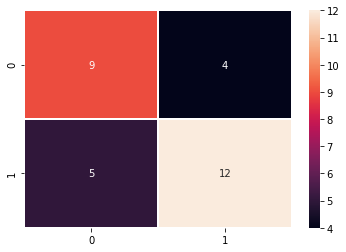

In [24]:
# y_test = [xray_class.get_label(x) for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
# y_val = [xray_class.get_unique_labels()[x] for x in test_data.labels]
y_test = [test_df.labels.unique()[np.argmax(x)] for x in predictions] # convert [0,25, 0.75] -> "No Finding/Effusion"
y_val = [test_df.labels.unique()[x] for x in test_data.labels]

xray_class.generate_confusion_matrix(y_test, y_val)

In [25]:
xray_class.generate_classification_report(y_test, y_val)

              precision    recall  f1-score   support

  No Finding       0.64      0.69      0.67        13
   Pneumonia       0.75      0.71      0.73        17

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30

